In [1]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

os_env = 'mac'


if os_env == 'window':

    emb_path_trn_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version(0313).npy'
    emb_path_vld_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version(0313).npy'

    emb_path_trn_eicu = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version(0313).npy'

    mimic_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0313).csv.gz'
    eicu_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0313).csv.gz'

    module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
    if module_path not in sys.path:
        sys.path.append(module_path)

    module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
    if module_path not in sys.path:
        sys.path.append(module_path)

else:
    emb_path_trn_mimic = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version(0313).npy'
    emb_path_vld_mimic = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version(0313).npy'

    emb_path_trn_eicu = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version(0313).npy'

    mimic_path = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Case Labeling/mimic_analysis(new_version0313).csv.gz'
    eicu_path = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Case Labeling/eicu_analysis(new_version0313).csv.gz'

    module_path = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Cohort_selection/'

    if module_path not in sys.path:
        sys.path.append(module_path)

    module_path = '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
    if module_path not in sys.path:
        sys.path.append(module_path)

from cohort_loader_new_version0229 import *
import eicu_year_process

import integrating_embedding
import get_hospital_eicu


mimic_train_emb, mimic_valid_emb, event = integrating_embedding.integrating_for_subtask(mimic_path, emb_path_trn_mimic, emb_path_vld_mimic, _,'mimic')
eicu_test_emb, event_eicu = integrating_embedding.integrating_for_subtask(eicu_path, emb_path_trn_eicu, _,_, 'eicu')

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    174346
2.0     27608
3.0     70171
4.0     71699
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    17664
2.0     3030
3.0     9456
4.0     8278
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.51:0.08:0.20:0.21
테스트셋 클래스 비율: 0.46:0.08:0.25:0.22
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 5323
테스트셋 환자 수: 601
학습셋 체류 수: 5433
테스트셋 체류 수: 604
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.1
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.59
시도한 시행 횟수: 0


In [7]:
eicu_test_emb = eicu_test_emb[~((eicu_test_emb['INDEX']=='CASE3_CASE4_DF')&(eicu_test_emb['Annotation']=='no_circ'))]
eicu_test_emb = eicu_test_emb[eicu_test_emb['INDEX']=='CASE3_CASE4_DF'].reset_index(drop=True)

,Time_since_ICU_admission,Unnamed: 0,ABPd,Cardiac Output_fillna,height_fillna,PEEP,Cardiac Output,PEEP_fillna,Sofa_Liver,Sofa_Cardiovascular,...,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78
0,197,1596549,48.583333,1,0,14.0,8.738223,0,2,2,...,-1.173577,-0.429366,-1.554870,-1.897868,-1.707313,3.489430,3.093396,0.695513,0.724622,2.150002
1,198,1596550,47.500000,1,0,14.0,8.738223,0,2,2,...,-1.719467,-0.437622,-2.060325,-1.997296,-1.747095,4.401869,3.978053,0.828737,0.762184,2.904873
2,199,1596551,51.500000,1,0,14.0,8.738223,0,2,2,...,-1.359259,-0.371697,-1.605313,-2.019530,-1.769784,3.685672,3.177766,0.731865,0.533949,2.429654
3,200,1596552,53.333333,1,0,14.0,8.738223,0,2,2,...,-1.046649,-0.442196,-1.276969,-2.035739,-1.758560,3.255942,2.701441,0.625020,0.581648,2.025850
4,201,1596553,53.916667,1,0,14.0,8.738223,0,2,2,...,-0.998691,-0.573738,-1.277437,-2.131838,-1.813961,3.422462,2.825990,0.629940,0.768344,2.023201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86670,799,913127,38.833333,1,0,5.0,6.246574,0,4,2,...,-3.129017,-0.684235,-3.495693,-2.384990,-1.792140,6.966107,6.106250,1.195446,0.969664,4.997853
86671,800,913128,42.500000,1,0,5.0,6.246574,0,4,2,...,-3.177992,-0.675438,-3.511378,-2.413897,-1.808695,7.041497,6.172299,1.213825,0.908980,5.095966
86672,801,913129,39.416667,1,0,5.0,6.246574,0,4,2,...,-3.132653,-0.670414,-3.455008,-2.377977,-1.822514,6.924135,6.092346,1.169881,0.905294,5.010855
86673,802,913130,40.083333,1,0,5.0,6.246574,0,4,2,...,-3.193873,-0.684336,-3.563440,-2.422044,-1.788382,7.108894,6.214455,1.241726,0.933231,5.136197


In [2]:
module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/sub task prediction/'

if module_path not in sys.path:
    sys.path.append(module_path)

import incorperate_subtask_label
from imp import reload
reload(incorperate_subtask_label)

<module 'incorperate_subtask_label' from '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Experiment(Supervised Learning)/sub task prediction/incorperate_subtask_label.py'>

In [8]:
# train, val -> Trainset (underfitting 방지)

mort_mimic_train, mort_mimic_valid, mort_eicu_test = incorperate_subtask_label.mortality_prediction_DATA(mimic_train_emb, mimic_valid_emb, eicu_test_emb, os_env='mac')
mimic_mort_trainset = pd.concat([mort_mimic_train, mort_mimic_valid], axis = 0)

los_mimic_train, los_mimic_valid, los_eicu_test = incorperate_subtask_label.LOS_prediction_DATA(mimic_train_emb, mimic_valid_emb, eicu_test_emb, os_env='mac')
mimic_los_trainset = pd.concat([los_mimic_train, los_mimic_valid], axis = 0)

ards8h_mimic_train, ards8h_mimic_valid, ards8h_eicu_test = incorperate_subtask_label.ARDS8_prediction_DATA(mimic_train_emb, mimic_valid_emb, eicu_test_emb, os_env='mac')
mimic_ards8h_trainset = pd.concat([ards8h_mimic_train, ards8h_mimic_valid], axis = 0)

sic8h_mimic_train, sic8h_mimic_valid, sic8h_eicu_test = incorperate_subtask_label.SIC8_prediction_DATA(mimic_train_emb, mimic_valid_emb, eicu_test_emb, os_env='mac')
mimic_sic8h__trainset = pd.concat([sic8h_mimic_train, sic8h_mimic_valid], axis = 0)

In [10]:
import get_hospital_eicu

#Mortality eicu test set stat...-----------------------------------------------------------------------------------------------------------------

view_mort = get_hospital_eicu.eicu_subgroup(mort_eicu_test)

mort_event_stat = view_mort[view_mort['death']=='event'].groupby('unittype').count()['death'].to_dict()
mort_obs_stat = view_mort.groupby('unittype').count()['Time_since_ICU_admission'].to_dict()
summary_mort = pd.DataFrame(list(zip(mort_event_stat.values(), mort_obs_stat.values())), index=mort_event_stat.keys(), columns=['N_evt', 'N_obs'])
summary_mort['N_obs(%)'] = summary_mort['N_obs'] / summary_mort['N_obs'].sum()

#LOS eicu test set stat...

view_los = get_hospital_eicu.eicu_subgroup(los_eicu_test)

view2 = pd.DataFrame(view_los.groupby('unittype')['remain_los'].value_counts(normalize=True)).reset_index()
view3 = pd.DataFrame(view_los.groupby('unittype').count()['Time_since_ICU_admission']).reset_index()

summary_los = pd.merge(view2, view3, how = 'inner', on=['unittype']).set_index(['unittype', 'Time_since_ICU_admission'])

#ARDS eicu test set stat...

view_ards = get_hospital_eicu.eicu_subgroup(ards8h_eicu_test)

ards_event_stat = view_ards[view_ards['Annotation_ARDS']=='ARDS'].groupby('unittype').count()['Annotation_ARDS'].to_dict()
ards_obs_stat = view_ards.groupby('unittype').count()['Time_since_ICU_admission'].to_dict()
summary_ards = pd.DataFrame(list(zip(ards_event_stat.values(), ards_obs_stat.values())), index=ards_event_stat.keys(), columns=['N_evt', 'N_obs'])
summary_ards['N_obs(%)'] = summary_ards['N_obs'] / summary_ards['N_obs'].sum()


#SIC eicu test set stat...

view_sic = get_hospital_eicu.eicu_subgroup(sic8h_eicu_test)

sic_event_stat = view_sic[view_sic['Annotation_SIC']=='SIC'].groupby('unittype').count()['Annotation_SIC'].to_dict()
sic_obs_stat = view_sic.groupby('unittype').count()['Time_since_ICU_admission'].to_dict()
summary_sic = pd.DataFrame(list(zip(sic_event_stat.values(), sic_obs_stat.values())), index=sic_event_stat.keys(), columns=['N_evt', 'N_obs'])
summary_sic['N_obs(%)'] = summary_sic['N_obs'] / summary_sic['N_obs'].sum()

#-----------------------------------------------------------------------------------------------

In [12]:
_, mort_unittype, _ = get_hospital_eicu.make_eicu_dataset(view_mort)
_, los_unittype, _ = get_hospital_eicu.make_eicu_dataset(view_los)
_, ards_unittype, _ = get_hospital_eicu.make_eicu_dataset(view_ards)
_, sic_unittype, _ = get_hospital_eicu.make_eicu_dataset(view_sic)

In [13]:
ARDS8h_event_train = mimic_ards8h_trainset[mimic_ards8h_trainset['Annotation_ARDS']=='ARDS']
ARDS8h_event_train['ARDS_next_8h']='event'

ARDS8h_event_test = ards8h_eicu_test[ards8h_eicu_test['Annotation_ARDS']=='ARDS']
ARDS8h_event_test['ARDS_next_8h']='event'

SIC8h_event_train = mimic_sic8h__trainset[mimic_sic8h__trainset['Annotation_SIC']=='SIC']
SIC8h_event_train['SIC_next_8h']='event'

SIC8h_event_test = sic8h_eicu_test[sic8h_eicu_test['Annotation_SIC']=='SIC']
SIC8h_event_test['SIC_next_8h']='event'

In [15]:
import split
from imp import reload
reload(split)

<module 'split' from '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Experiment(Supervised Learning)/evaluation/split.py'>

In [16]:
X_train_mort, y_train_mort, _ = split.split_X_Y_MORT(mimic_mort_trainset[~(mimic_mort_trainset['death']=='event')], mode = 'mimic')
X_train_los, y_train_los, _ = split.split_X_Y_LOS(mimic_los_trainset, mode = 'mimic')
X_train_ards8h, y_train_ards8h, _ = split.split_X_Y_ARDS8h(mimic_ards8h_trainset, mode = 'mimic')
X_train_sic8h, y_train_sic8h, _ = split.split_X_Y_SIC8h(mimic_sic8h__trainset, mode = 'mimic')

In [17]:
import Multiclass_evaluation
reload(Multiclass_evaluation)

<module 'Multiclass_evaluation' from '/Users/gwonjeong-eul/Desktop/ecp-scl-macbook/ECP_SCL/Experiment(Supervised Learning)/evaluation/Multiclass_evaluation.py'>

In [18]:
#mortality

mort_models = Multiclass_evaluation.create_subtask(X_train_mort, y_train_mort)
mort_evaluation_result = Multiclass_evaluation.unit_mort_evaluation(mort_unittype, mort_models)

==Start training==
..
==Complete Training==
[Starting eICU-Test]
eICU-UnitType...


Model     AUROC     AUPRC
Subpopulation eICU Type                                   
UnitType      MICU                 xgb  0.458144  0.354896
              MICU                lgbm  0.504077  0.377283
              MICU            catboost  0.431109  0.312359
              MICU                  rf  0.489883  0.399263
              MICU                  lr  0.528447  0.407979
              MICU          naivebayes  0.559437  0.379971
              MICU                 knn  0.453108  0.380581
              Neuro ICU            xgb  0.473000  0.251146
              Neuro ICU           lgbm  0.630073  0.430149
              Neuro ICU       catboost  0.590040  0.361683
              Neuro ICU             rf  0.669645  0.425399
              Neuro ICU             lr  0.307677  0.240185
              Neuro ICU     naivebayes  0.460432  0.228524
              Neuro ICU            knn  0.606489  0.427233
              Med-Surg ICU         xgb  0.475488  0.341046
              Med-Surg ICU        lgbm  0.530205  0.374885
              Med-Surg ICU    catboost  0.457713  0.302701
              Med-Surg ICU          rf  0.560841  0.391630
              Med-Surg ICU          lr  0.423978  0.359462
              Med-Surg ICU  naivebayes  0.524389  0.373923
              Med-Surg ICU         knn  0.507753  0.402994
              Cardiac ICU          xgb  0.508457  0.311246
              Cardiac ICU         lgbm  0.581583  0.339421
              Cardiac ICU     catboost  0.590597  0.463203
              Cardiac ICU           rf  0.623203  0.476749
              Cardiac ICU           lr  0.483108  0.350439
              Cardiac ICU   naivebayes  0.532452  0.372017
              Cardiac ICU          knn  0.525977  0.380669
              SICU                 xgb  0.456953  0.311687
              SICU                lgbm  0.479337  0.315646
              SICU            catboost  0.534747  0.342749
              SICU                  rf  0.538149  0.362144
              SICU                  lr  0.463862  0.393514
              SICU          naivebayes  0.500826  0.445846
              SICU                 knn  0.514955  0.402991
              CTICU                xgb  0.547427  0.363724
              CTICU               lgbm  0.540924  0.338295
              CTICU           catboost  0.480689  0.301455
              CTICU                 rf  0.521469  0.343222
              CTICU                 lr  0.562280  0.431074
              CTICU         naivebayes  0.584393  0.421755
              CTICU                knn  0.550615  0.450225
              CSICU                xgb  0.462354  0.278344
              CSICU               lgbm  0.496862  0.309487
              CSICU           catboost  0.447075  0.261121
              CSICU                 rf  0.461096  0.287634
              CSICU                 lr  0.608874  0.456960
              CSICU         naivebayes  0.613098  0.404893
              CSICU                knn  0.547073  0.408277
              CCU-CTICU            xgb  0.449069  0.320190
              CCU-CTICU           lgbm  0.372573  0.319605
              CCU-CTICU       catboost  0.450993  0.342729
              CCU-CTICU             rf  0.530155  0.400620
              CCU-CTICU             lr  0.400954  0.366851
              CCU-CTICU     naivebayes  0.480104  0.333353
              CCU-CTICU            knn  0.567219  0.429468

In [22]:
mort_result_summary = pd.DataFrame()
result = mort_evaluation_result.reset_index()
for unittype in result['eICU Type'].unique():
    unittype_group = result[result['eICU Type'] == unittype]
    for metric in ['AUROC', 'AUPRC']:
        data = unittype_group[metric]
        mean, ci_lower, ci_upper = Multiclass_evaluation.mean_confidence_interval(data)
        summary = pd.DataFrame([{
            'UnitType': unittype,
            'Metric': metric,
            'Mean': mean,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        }])

        mort_result_summary = pd.concat([mort_result_summary, summary])

# 결과 출력을 위해 필요한 컬럼 순서 조정
mort_result_summary = mort_result_summary[['UnitType', 'Metric', 'Mean', '95% CI Lower', '95% CI Upper']]

display(mort_result_summary.set_index(['UnitType', 'Metric']).transpose())

UnitType          MICU           Neuro ICU           Med-Surg ICU            \
Metric           AUROC     AUPRC     AUROC     AUPRC        AUROC     AUPRC   
Mean          0.489172  0.373190  0.533908  0.337760     0.497195  0.363806   
95% CI Lower  0.447235  0.343841  0.416692  0.250225     0.453518  0.332658   
95% CI Upper  0.531110  0.402540  0.651124  0.425294     0.540873  0.394954   

UnitType     Cardiac ICU                SICU               CTICU            \
Metric             AUROC     AUPRC     AUROC     AUPRC     AUROC     AUPRC   
Mean            0.549340  0.384821  0.498404  0.367796  0.541114  0.378536   
95% CI Lower    0.502964  0.327024  0.468069  0.322302  0.510701  0.326774   
95% CI Upper    0.595715  0.442617  0.528739  0.413291  0.571527  0.430298   

UnitType         CSICU           CCU-CTICU            
Metric           AUROC     AUPRC     AUROC     AUPRC  
Mean          0.519490  0.343817  0.464438  0.358974  
95% CI Lower  0.454156  0.272032  0.401243  0.319845  
95% CI Upper  0.584825  0.415601  0.527634  0.398103

In [20]:
#los

los_models = Multiclass_evaluation.create_subtask(X_train_los, y_train_los)
los_evaluation_result = Multiclass_evaluation.unit_los_evaluation(los_unittype, los_models)

==Start training==
..
==Complete Training==
[Starting eICU-Test]
eICU-UnitType...


Model  AUROC < 5days  AUROC < 10days  \
Subpopulation eICU Type                                                 
UnitType      MICU                 xgb       0.685088        0.572009   
              MICU                lgbm       0.745301        0.628603   
              MICU            catboost       0.746077        0.615227   
              MICU                  rf       0.734414        0.592071   
              MICU                  lr       0.535944        0.407514   
              MICU          naivebayes       0.665177        0.579063   
              MICU                 knn       0.723337        0.596363   
              Neuro ICU            xgb       0.831832        0.516999   
              Neuro ICU           lgbm       0.900947        0.529416   
              Neuro ICU       catboost       0.886087        0.615618   
              Neuro ICU             rf       0.897650        0.618158   
              Neuro ICU             lr       0.529537        0.383225   
              Neuro ICU     naivebayes       0.652935        0.507255   
              Neuro ICU            knn       0.818413        0.625488   
              Med-Surg ICU         xgb       0.789414        0.616189   
              Med-Surg ICU        lgbm       0.812947        0.652721   
              Med-Surg ICU    catboost       0.814002        0.657046   
              Med-Surg ICU          rf       0.789756        0.606706   
              Med-Surg ICU          lr       0.532721        0.402110   
              Med-Surg ICU  naivebayes       0.712216        0.552554   
              Med-Surg ICU         knn       0.690368        0.540140   
              Cardiac ICU          xgb       0.768054        0.589094   
              Cardiac ICU         lgbm       0.854945        0.718402   
              Cardiac ICU     catboost       0.812326        0.670343   
              Cardiac ICU           rf       0.817474        0.654738   
              Cardiac ICU           lr       0.518075        0.358741   
              Cardiac ICU   naivebayes       0.671337        0.590956   
              Cardiac ICU          knn       0.660697        0.532812   
              SICU                 xgb       0.781844        0.566132   
              SICU                lgbm       0.797133        0.603214   
              SICU            catboost       0.809983        0.568795   
              SICU                  rf       0.805812        0.581108   
              SICU                  lr       0.541576        0.473114   
              SICU          naivebayes       0.657077        0.502472   
              SICU                 knn       0.736448        0.538088   
              CTICU                xgb       0.625402        0.648895   
              CTICU               lgbm       0.681198        0.716860   
              CTICU           catboost       0.700698        0.735553   
              CTICU                 rf       0.670102        0.690022   
              CTICU                 lr       0.512482        0.339302   
              CTICU         naivebayes       0.608351        0.625402   
              CTICU                knn       0.396977        0.515095   
              CSICU                xgb       0.695908        0.580427   
              CSICU               lgbm       0.735257        0.648074   
              CSICU           catboost       0.702408        0.613295   
              CSICU                 rf       0.713938        0.572985   
              CSICU                 lr       0.536009        0.365489   
              CSICU         naivebayes       0.653558        0.586788   
              CSICU                knn       0.623597        0.487587   
              CCU-CTICU            xgb       0.805151        0.690043   
              CCU-CTICU           lgbm       0.787842        0.663956   
              CCU-CTICU       catboost       0.804518        0.727124   
              CCU-CTICU             rf       0.776966        0.594372   
              CCU-

In [24]:
pd.set_option('display.max_columns', None)
los_result_summary = pd.DataFrame()
result = los_evaluation_result.reset_index()
for unittype in result['eICU Type'].unique():
    unittype_group = result[result['eICU Type'] == unittype]
    for metric in ['AUROC < 5days','AUROC < 10days', 'AUROC >= 15days', 'AUPRC < 5days', 'AUPRC < 10days', 'AUPRC >= 15days']:
        data = unittype_group[metric]
        mean, ci_lower, ci_upper = Multiclass_evaluation.mean_confidence_interval(data)
        summary = pd.DataFrame([{
            'UnitType': unittype,
            'Metric': metric,
            'Mean': mean,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        }])

        los_result_summary = pd.concat([los_result_summary, summary])

# 결과 출력을 위해 필요한 컬럼 순서 조정
los_result_summary = los_result_summary[['UnitType', 'Metric', 'Mean', '95% CI Lower', '95% CI Upper']]

display(los_result_summary.set_index(['UnitType', 'Metric']).transpose())

UnitType              MICU                                               \
Metric       AUROC < 5days AUROC < 10days AUROC >= 15days AUPRC < 5days   
Mean              0.690762       0.570121        0.729420      0.818074   
95% CI Lower      0.621495       0.501378        0.641863      0.795859   
95% CI Upper      0.760030       0.638865        0.816977      0.840289   

UnitType                                        Neuro ICU                 \
Metric       AUPRC < 10days AUPRC >= 15days AUROC < 5days AUROC < 10days   
Mean               0.245843        0.417305      0.788200       0.542308   
95% CI Lower       0.205979        0.324533      0.656163       0.461868   
95% CI Upper       0.285707        0.510078      0.920237       0.622748   

UnitType                                                                   \
Metric       AUROC >= 15days AUPRC < 5days AUPRC < 10days AUPRC >= 15days   
Mean                0.765211      0.791831       0.218177        0.632993   
95% CI Lower        0.639251      0.742576       0.161941        0.506284   
95% CI Upper        0.891170      0.841085       0.274413        0.759701   

UnitType      Med-Surg ICU                                               \
Metric       AUROC < 5days AUROC < 10days AUROC >= 15days AUPRC < 5days   
Mean              0.734489       0.575352        0.769356      0.792119   
95% CI Lower      0.640702       0.493426        0.673976      0.767119   
95% CI Upper      0.828276       0.657279        0.864735      0.817118   

UnitType                                      Cardiac ICU                 \
Metric       AUPRC < 10days AUPRC >= 15days AUROC < 5days AUROC < 10days   
Mean               0.262330        0.570104      0.728987       0.587870   
95% CI Lower       0.209177        0.483383      0.619143       0.478535   
95% CI Upper       0.315483        0.656824      0.838831       0.697204   

UnitType                                                                   \
Metric       AUROC >= 15days AUPRC < 5days AUPRC < 10days AUPRC >= 15days   
Mean                0.722677      0.808494       0.237381        0.574518   
95% CI Lower        0.628053      0.763821       0.185591        0.465007   
95% CI Upper        0.817301      0.853166       0.289172        0.684029   

UnitType              SICU                                               \
Metric       AUROC < 5days AUROC < 10days AUROC >= 15days AUPRC < 5days   
Mean              0.732839       0.547560        0.765357      0.775853   
95% CI Lower      0.640242       0.505039        0.671202      0.736306   
95% CI Upper      0.825436       0.590082        0.859513      0.815400   

UnitType                                            CTICU                 \
Metric       AUPRC < 10days AUPRC >= 15days AUROC < 5days AUROC < 10days   
Mean               0.201896        0.607136      0.599316       0.610161   
95% CI Lower       0.179582        0.492453      0.498542       0.480672   
95% CI Upper       0.224209        0.721818      0.700089       0.739651   

UnitType                                                                   \
Metric       AUROC >= 15days AUPRC < 5days AUPRC < 10days AUPRC >= 15days   
Mean                0.503009      0.794769       0.350988        0.146248   
95% CI Lower        0.434018      0.748823       0.261366        0.000308   
95% CI Upper        0.572001      0.840715       0.440609        0.292189   

UnitType             CSICU                                               \
Metric       AUROC < 5days AUROC < 10days AUROC >= 15days AUPRC < 5days   
Mean              0.665811       0.550663        0.688378      0.796219   
95% CI Lower      0.602446       0.462626        0.619198      0.772926   
95% CI Upper      0.729175       0.638701        0.757558      0.819512   

UnitType                                        CCU-CTICU                 \
Metric       AUPRC < 10days AUPRC >= 15days AUROC < 5days AUROC < 10days   
Mean               0.267683        0.317355

In [30]:
#ARDS
reload(Multiclass_evaluation)
# models = Multiclass_evaluation.create_subtask(X_train_ards8h, y_train_ards8h)
ards_evaluation_result = Multiclass_evaluation.unit_ards_evaluation(ards_unittype, models, ARDS8h_event_test)

[Starting eICU-Test]
eICU-UnitType...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivi

Model     AUPRC  ARDS score
Subpopulation eICU Type                                     
UnitType      Neuro ICU            xgb  0.840060    0.590909
              Neuro ICU           lgbm  0.666406    0.187418
              Neuro ICU       catboost  0.755785    0.291262
              Neuro ICU             rf  0.635262    0.236057
              Neuro ICU             lr  0.598183    0.591724
              Neuro ICU     naivebayes  0.866372    0.000000
              Neuro ICU            knn  0.679737    0.328155
              Cardiac ICU          xgb  0.780064    0.000000
              Cardiac ICU         lgbm  0.828626    0.152941
              Cardiac ICU     catboost  0.779993    0.109705
              Cardiac ICU           rf  0.788363    0.080997
              Cardiac ICU           lr  0.600343    0.033121
              Cardiac ICU   naivebayes  0.558308    0.000000
              Cardiac ICU          knn  0.600000    0.013252
              Med-Surg ICU         xgb  0.502682    0.097170
              Med-Surg ICU        lgbm  0.485081    0.149821
              Med-Surg ICU    catboost  0.533057    0.271982
              Med-Surg ICU          rf  0.496709    0.209613
              Med-Surg ICU          lr  0.429303    0.161334
              Med-Surg ICU  naivebayes  0.407508    0.000000
              Med-Surg ICU         knn  0.195141    0.151075
              SICU                 xgb  0.857422    0.387936
              SICU                lgbm  0.895060    0.314927
              SICU            catboost  0.873202    0.373509
              SICU                  rf  0.919965    0.303738
              SICU                  lr  0.874557    0.144741
              SICU          naivebayes  0.370769    0.000000
              SICU                 knn  0.652783    0.075865
              MICU                 xgb  0.534144    0.106537
              MICU                lgbm  0.510522    0.216152
              MICU            catboost  0.549707    0.329043
              MICU                  rf  0.380723    0.254157
              MICU                  lr  0.380420    0.225887
              MICU          naivebayes  0.347102    0.000000
              MICU                 knn  0.281997    0.188555
              CTICU                xgb  1.000000    0.333333
              CTICU               lgbm  1.000000    0.419355
              CTICU           catboost  0.950000    0.374486
              CTICU                 rf  1.000000    0.270833
              CTICU                 lr  0.912879    0.024519
              CTICU         naivebayes  1.000000    0.000000
              CTICU                knn  0.816667    0.024593
              CSICU                xgb  0.150514    0.000000
              CSICU               lgbm  0.185279    0.000000
              CSICU           catboost  0.241047    0.000000
              CSICU                 rf  0.340502    0.189350
              CSICU                 lr  0.218487    0.114046
              CSICU         naivebayes  0.299889    0.000000
              CSICU                knn  0.147193    0.169589
              CCU-CTICU            xgb  0.948944    0.000000
              CCU-CTICU           lgbm  0.911586    0.329101
              CCU-CTICU       catboost  0.913529    0.146569
              CCU-CTICU             rf  0.947176    0.093538
              CCU-CTICU             lr  0.682223    0.079108
              CCU-CTICU     naivebayes  0.728558    0.000000
              CCU-CTICU            knn  0.815462    0.070884

In [31]:
ards_result_summary = pd.DataFrame()
result = ards_evaluation_result.reset_index()
for unittype in result['eICU Type'].unique():
    unittype_group = result[result['eICU Type'] == unittype]
    for metric in ['AUPRC', 'ARDS score']:
        data = unittype_group[metric]
        mean, ci_lower, ci_upper = Multiclass_evaluation.mean_confidence_interval(data)
        summary = pd.DataFrame([{
            'UnitType': unittype,
            'Metric': metric,
            'Mean': mean,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        }])

        ards_result_summary = pd.concat([ards_result_summary, summary])

# 결과 출력을 위해 필요한 컬럼 순서 조정
ards_result_summary = ards_result_summary[['UnitType', 'Metric', 'Mean', '95% CI Lower', '95% CI Upper']]

display(ards_result_summary.set_index(['UnitType', 'Metric']).transpose()) #AUPRC만 보자 얘는 

UnitType     Neuro ICU            Cardiac ICU            Med-Surg ICU  \
Metric           AUPRC ARDS score       AUPRC ARDS score        AUPRC   
Mean          0.720258   0.317932    0.705099   0.055717     0.435640   
95% CI Lower  0.625015   0.119894    0.600337   0.000317     0.329632   
95% CI Upper  0.815501   0.515970    0.809862   0.111116     0.541648   

UnitType                     SICU                 MICU                CTICU  \
Metric       ARDS score     AUPRC ARDS score     AUPRC ARDS score     AUPRC   
Mean           0.148714  0.777680   0.228674  0.426374   0.188619  0.954221   
95% CI Lower   0.069656  0.592685   0.086344  0.329942   0.089817  0.889889   
95% CI Upper   0.227771  0.962675   0.371003  0.522806   0.287420  1.018552   

UnitType                    CSICU            CCU-CTICU             
Metric       ARDS score     AUPRC ARDS score     AUPRC ARDS score  
Mean           0.206731  0.226130   0.067569  0.849640   0.102743  
95% CI Lower   0.036784  0.158147  -0.013111  0.748927  -0.001297  
95% CI Upper   0.376679  0.294113   0.148250  0.950352   0.206782

In [32]:
#SIC
reload(Multiclass_evaluation)
# sic_models = Multiclass_evaluation.create_subtask(X_train_sic8h, y_train_sic8h)
sic_evaluation_result = Multiclass_evaluation.unit_sic_evaluation(sic_unittype, sic_models, SIC8h_event_test)

[Starting eICU-Test]
eICU-UnitType...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivi

Model     AUPRC  SIC score
Subpopulation eICU Type                                    
UnitType      Med-Surg ICU         xgb  0.572357   0.227912
              Med-Surg ICU        lgbm  0.560885   0.306406
              Med-Surg ICU    catboost  0.559921   0.237869
              Med-Surg ICU          rf  0.530065   0.155381
              Med-Surg ICU          lr  0.400091   0.303741
              Med-Surg ICU  naivebayes  0.426219   0.252979
              Med-Surg ICU         knn  0.324508   0.217795
              MICU                 xgb  0.604096   0.267731
              MICU                lgbm  0.641579   0.293103
              MICU            catboost  0.551942   0.288987
              MICU                  rf  0.633719   0.083758
              MICU                  lr  0.450167   0.517785
              MICU          naivebayes  0.532964   0.410962
              MICU                 knn  0.244285   0.233285
              Neuro ICU            xgb  0.536118   0.000000
              Neuro ICU           lgbm  0.346390   0.000000
              Neuro ICU       catboost  0.309296   0.237027
              Neuro ICU             rf  0.415092   0.426230
              Neuro ICU             lr  0.305388   0.402250
              Neuro ICU     naivebayes  0.452930   0.366935
              Neuro ICU            knn  0.379989   0.218855
              CCU-CTICU            xgb  0.798677   0.000000
              CCU-CTICU           lgbm  1.000000   0.000000
              CCU-CTICU       catboost  0.836667   0.000000
              CCU-CTICU             rf  0.689931   0.000000
              CCU-CTICU             lr  0.144275   0.000000
              CCU-CTICU     naivebayes  0.337811   0.039731
              CCU-CTICU            knn  1.000000   0.053498
              SICU                 xgb  0.556944   0.426230
              SICU                lgbm  0.600104   0.475610
              SICU            catboost  0.419685   0.345515
              SICU                  rf  0.480253   0.000000
              SICU                  lr  0.252794   0.264706
              SICU          naivebayes  0.323854   0.143207
              SICU                 knn  0.373691   0.351351
              CSICU                xgb  0.594411   0.122807
              CSICU               lgbm  0.616521   0.124227
              CSICU           catboost  0.649241   0.232034
              CSICU                 rf  0.540347   0.126214
              CSICU                 lr  0.346104   0.213115
              CSICU         naivebayes  0.314525   0.269014
              CSICU                knn  0.319228   0.173438
              Cardiac ICU          xgb  0.405519   0.265607
              Cardiac ICU         lgbm  0.321393   0.230088
              Cardiac ICU     catboost  0.366124   0.140334
              Cardiac ICU           rf  0.399678   0.152146
              Cardiac ICU           lr  0.286885   0.233933
              Cardiac ICU   naivebayes  0.347752   0.246575
              Cardiac ICU          knn  0.234412   0.230088
              CTICU                xgb  0.478099   0.496183
              CTICU               lgbm  0.583086   0.383104
              CTICU           catboost  0.714784   0.568750
              CTICU                 rf  0.697500   0.224138
              CTICU                 lr  0.355906   0.349896
              CTICU         naivebayes  0.267969   0.474747
              CTICU                knn  0.433627   0.355191

In [33]:
sic_result_summary = pd.DataFrame()
result = sic_evaluation_result.reset_index()
for unittype in result['eICU Type'].unique():
    unittype_group = result[result['eICU Type'] == unittype]
    for metric in ['AUPRC', 'SIC score']:
        data = unittype_group[metric]
        mean, ci_lower, ci_upper = Multiclass_evaluation.mean_confidence_interval(data)
        summary = pd.DataFrame([{
            'UnitType': unittype,
            'Metric': metric,
            'Mean': mean,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        }])

        sic_result_summary = pd.concat([sic_result_summary, summary])

# 결과 출력을 위해 필요한 컬럼 순서 조정
sic_result_summary = sic_result_summary[['UnitType', 'Metric', 'Mean', '95% CI Lower', '95% CI Upper']]

display(sic_result_summary.set_index(['UnitType', 'Metric']).transpose())

UnitType     Med-Surg ICU                MICU           Neuro ICU            \
Metric              AUPRC SIC score     AUPRC SIC score     AUPRC SIC score   
Mean             0.482007  0.243155  0.522679  0.299373  0.392172  0.235900   
95% CI Lower     0.391553  0.194839  0.393631  0.172924  0.315180  0.070175   
95% CI Upper     0.572460  0.291471  0.651727  0.425822  0.469164  0.401624   

UnitType     CCU-CTICU                SICU               CSICU            \
Metric           AUPRC SIC score     AUPRC SIC score     AUPRC SIC score   
Mean          0.686766  0.013318  0.429618  0.286660  0.482911  0.180121   
95% CI Lower  0.382994 -0.008036  0.314154  0.132797  0.344127  0.125348   
95% CI Upper  0.990537  0.034673  0.545082  0.440522  0.621695  0.234895   

UnitType     Cardiac ICU               CTICU            
Metric             AUPRC SIC score     AUPRC SIC score  
Mean            0.337395  0.214110  0.504424  0.407430  
95% CI Lower    0.280301  0.169609  0.348114  0.301536  
95% CI Upper    0.394488  0.258612  0.660735  0.513324

In [41]:
sic_result_summary.set_index(['UnitType', 'Metric']).transpose().to_csv('proposed_method_subtask_sic.csv')
ards_result_summary.set_index(['UnitType', 'Metric']).transpose().to_csv('proposed_method_subtask_ards.csv')
los_result_summary.set_index(['UnitType', 'Metric']).transpose().to_csv('proposed_method_subtask_los.csv')
mort_result_summary.set_index(['UnitType', 'Metric']).transpose().to_csv('proposed_method_subtask_mort.csv')

LGBMClassifier(random_state=42, verbose=-1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

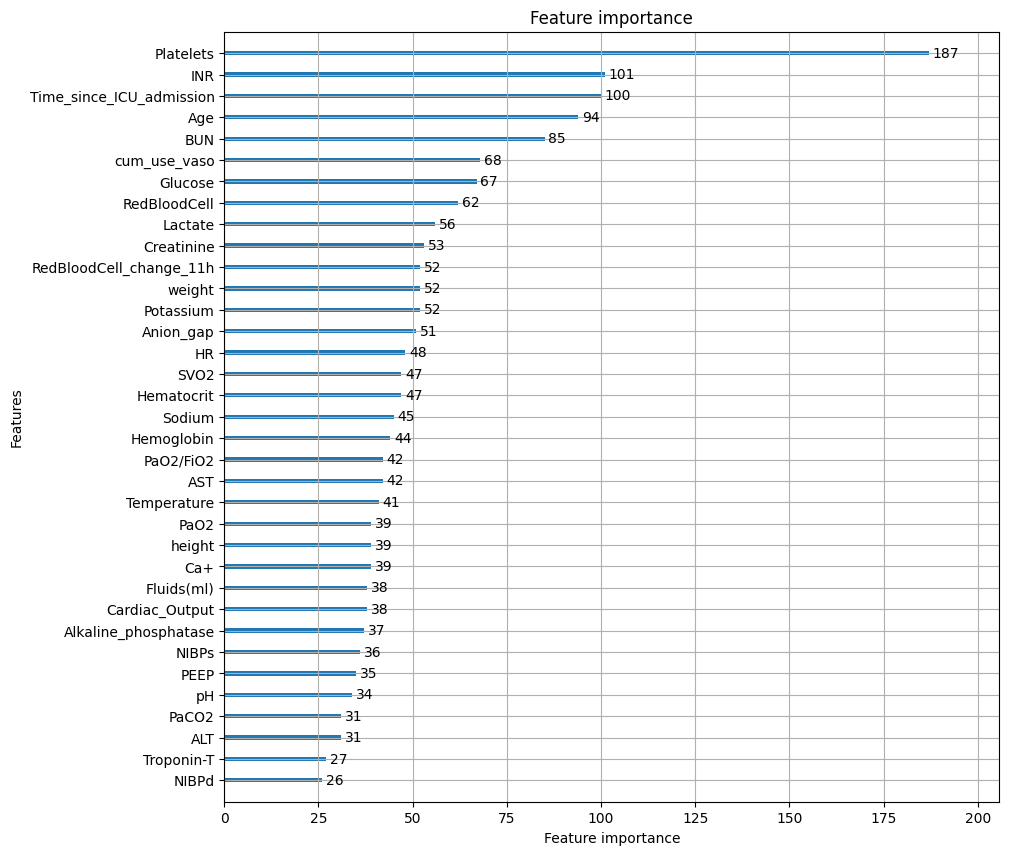

In [43]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,10))
plot_importance(sic_models['lgbm'], max_num_features=35, ax = ax)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

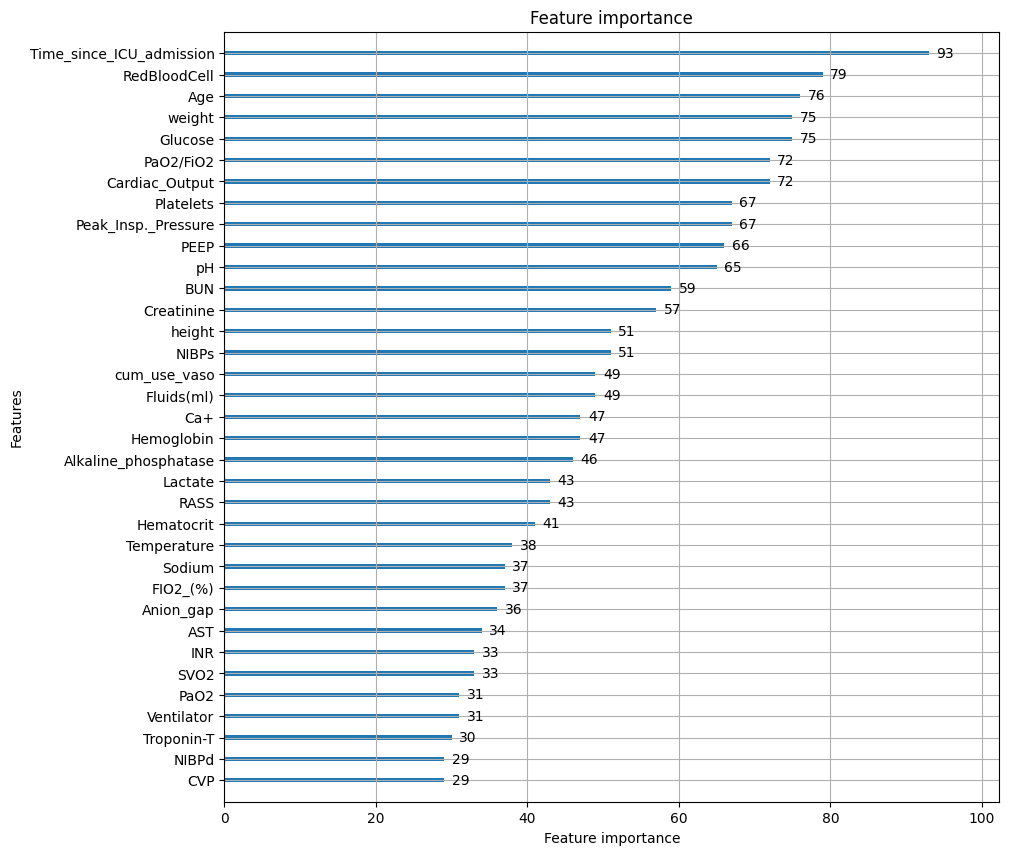

In [44]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,10))
plot_importance(models['lgbm'], max_num_features=35, ax = ax)